In [4]:
#here we test all the components.

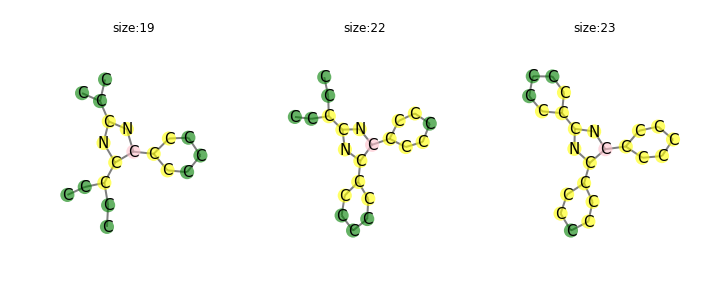

In [1]:

'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


#get a graph
gr = gspan_to_eden( 'bursi.pos.gspan' )
g=gr.next()


#lets see..
a=gl.extract_core_and_interface(1,g,radius_list=[2,3,4],thickness_list=[2],vectorizer=myed.GraphLearnVectorizer())
ng=myutils.cip_to_graph(a) 
myutils.draw_many_graphs(ng)



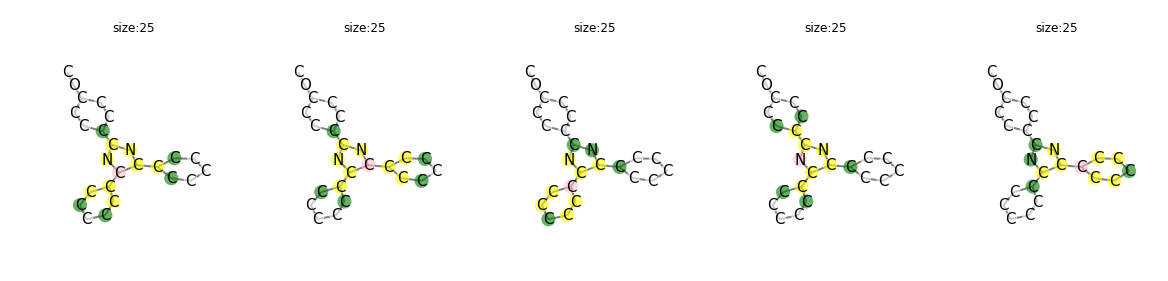

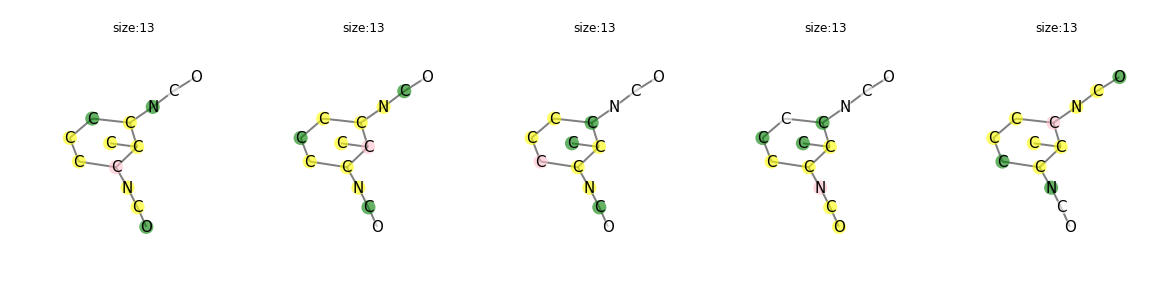

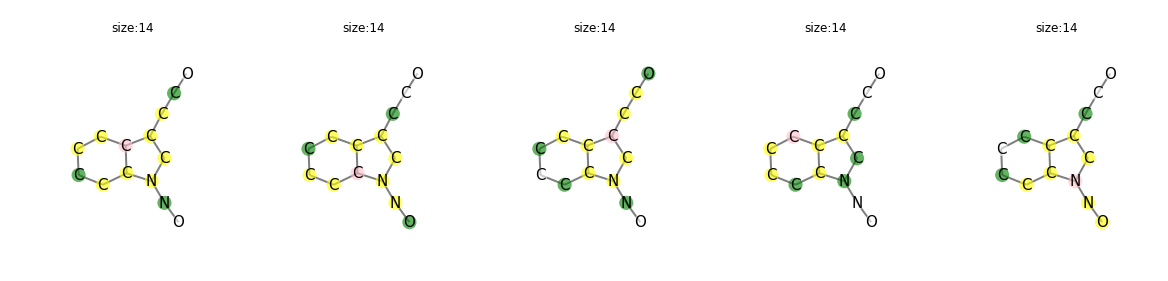

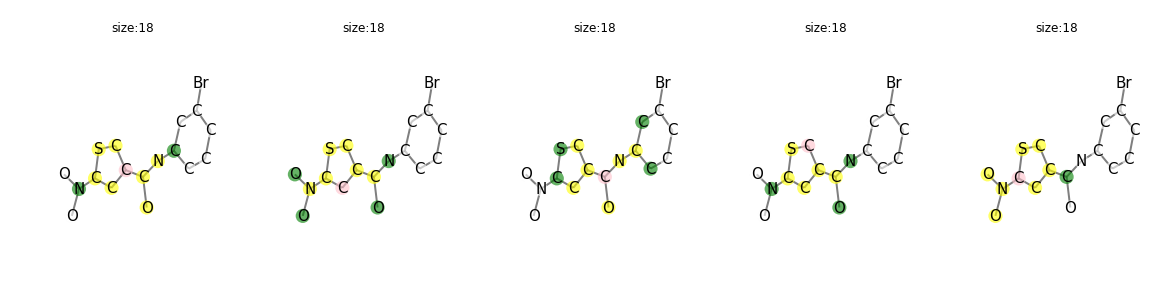

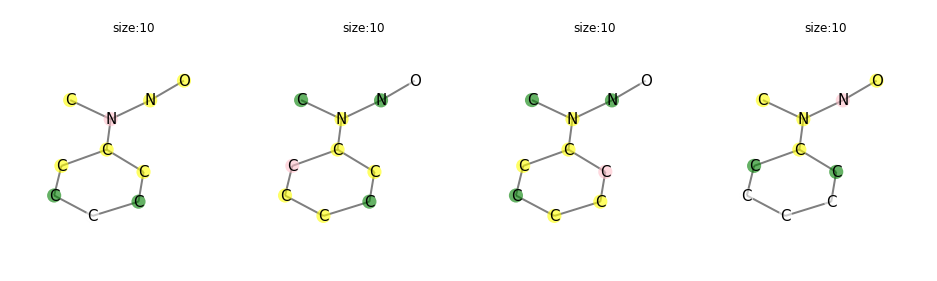

In [2]:
'''
demonstrating more extract core
'''
%matplotlib inline
import sys
sys.path.append('..')
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import graphlearn.utils.myeden as myed
import eden.graph as eg
import graphlearn.graphlearn as gl


#get 5 grtaphs...
gr = gspan_to_eden( 'bursi.pos.gspan' )
for x in range (5):
    g=gr.next()
    # for each, pick 5 cores and extract cips 
    nice_graphs=[]
    for n in range(5):
        node=n
        a=gl.extract_core_and_interface(node,g,radius_list=[3],thickness_list=[1],vectorizer=myed.GraphLearnVectorizer())
        # draw cip on the original graph and save in nice_graphs
        nice_graphs+=myutils.cip_to_graph(a, graphs=[g,g]) 
        
    # draw nice_graphs
    myutils.draw_many_graphs(nice_graphs)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.000720308245438, average=False, class_weight=None,
       epsilon=0.1, eta0=0.241211841115, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='hinge', n_iter=36, n_jobs=1,
       penalty='l1', power_t=0.395916917752, random_state=None,
       shuffle=True, verbose=0, warm_start=False),
            cv=3, method='sigmoid')
interface: 787182


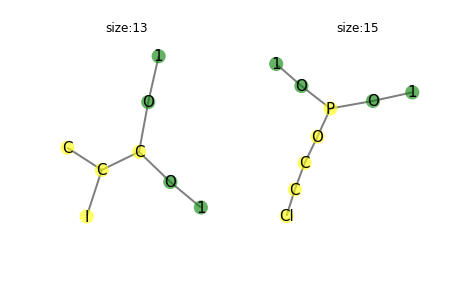

interface: 213748


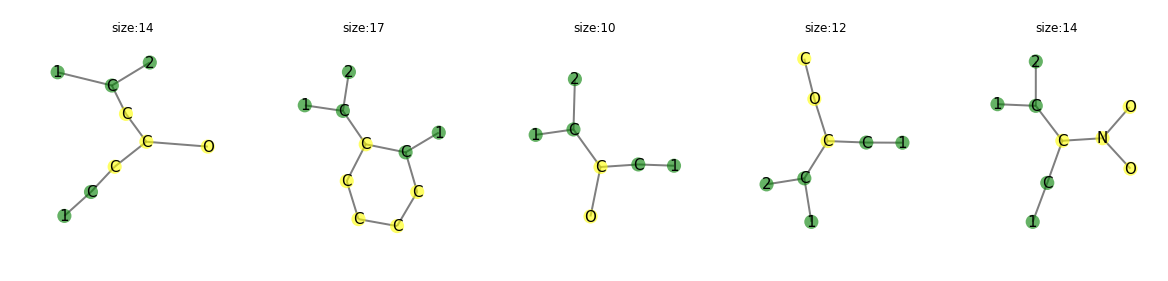

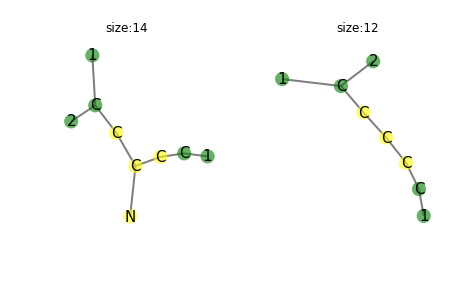

interface: 852737


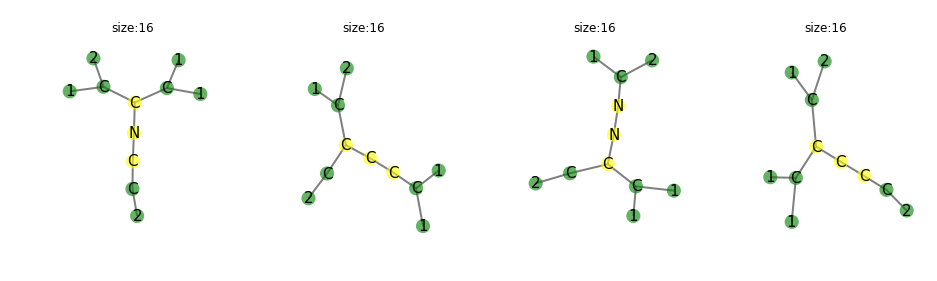

interface: 435029


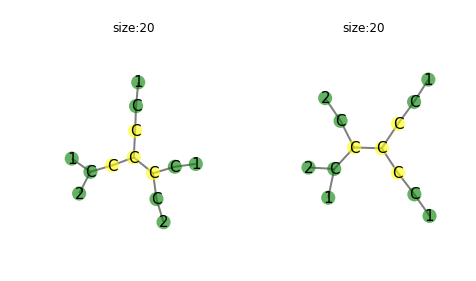

interface: 353420


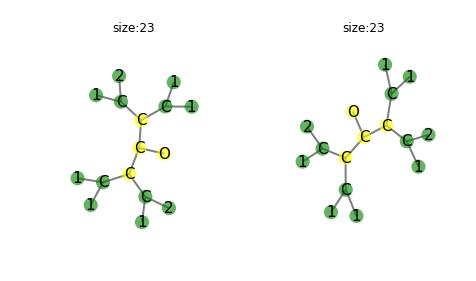

how often do we see interfacehashes
sum cips: 76
distinct interfaces: 24 (seen on x axis)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


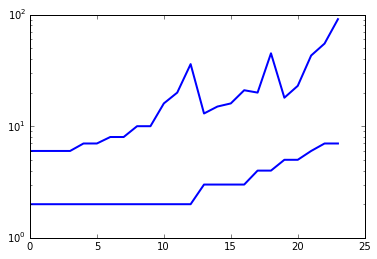

how often was this corehash seen?
sum cips: 76
distinct cores: 41 (seen on x axis)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


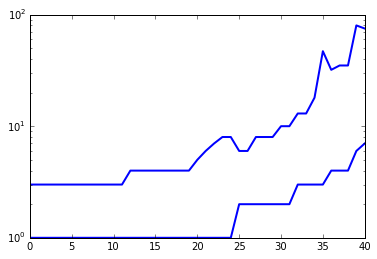

CPU times: user 7.95 s, sys: 574 ms, total: 8.52 s
Wall time: 22.1 s


In [1]:
%%time
'''
second is reading a grammar and training an estimator
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
gr = gspan_to_eden( 'bursi.pos.gspan' )


# we just learn a grammar from 50 graphs..  
gr = itertools.islice(gr,50)
sampler=gl.GraphLearnSampler()
#sampler=sampler.load('tmp/demo.ge')
sampler.fit(gr,n_jobs=4)


# we look at the estimator and  draw 5 interfaces with their associated cores
print sampler.estimator
#sampler.save('tmp/demo.ge')
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,5)



# here we look at some stats.
myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar)

loading done


DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
DEBUG:log:graph non existent
select_cips_from_grammar didn't find any acceptable cip; entries_found 17
INFO:log:select_cips_from_grammar didn't find any acceptable cip; entries_found 17


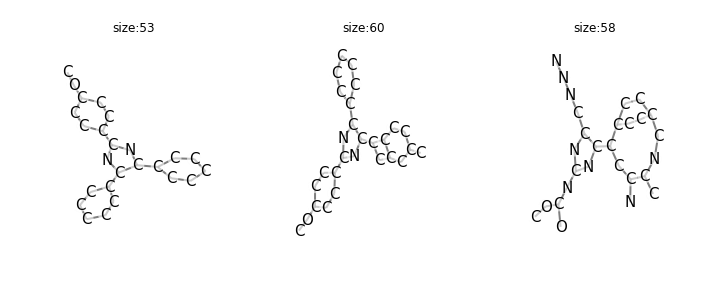

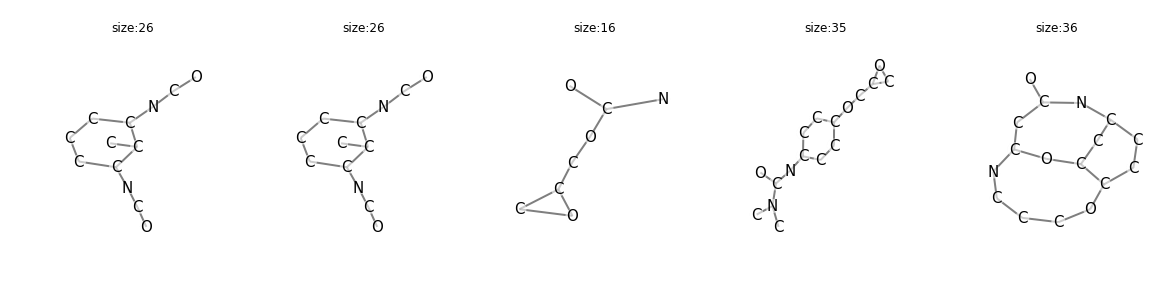

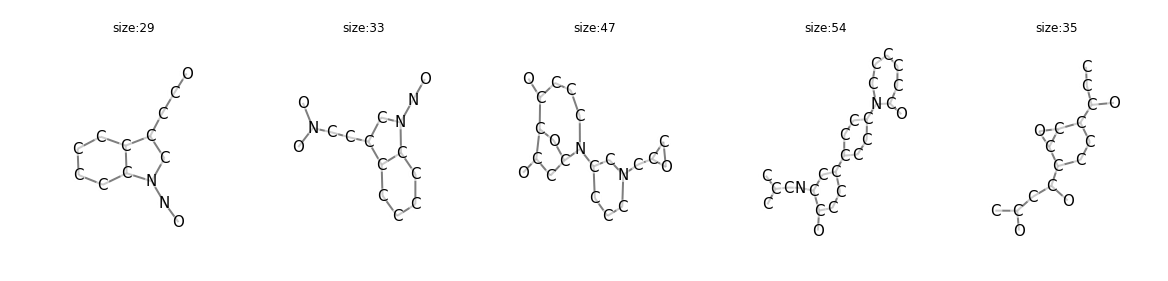

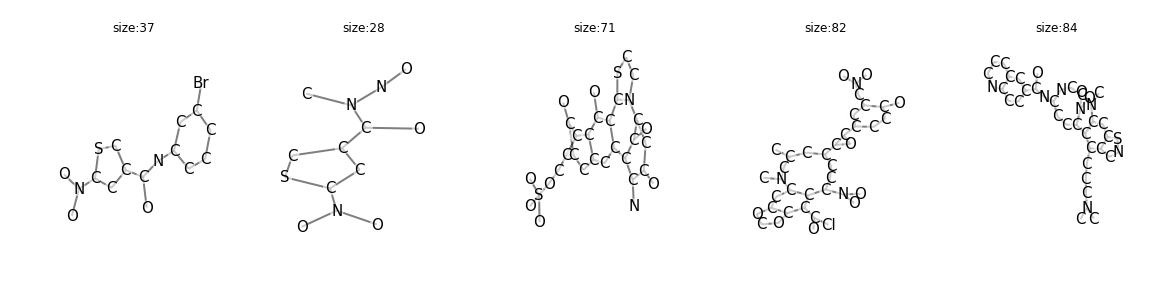

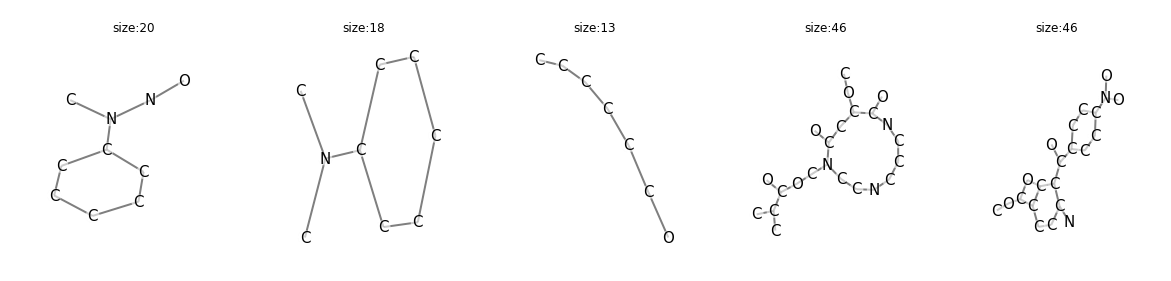

DEBUG:log:select_cip_for_substitution failed because no suiting interface was found, extract failed 20 times 
'NoneType' object has no attribute 'interface_hash'
INFO:log:'NoneType' object has no attribute 'interface_hash'


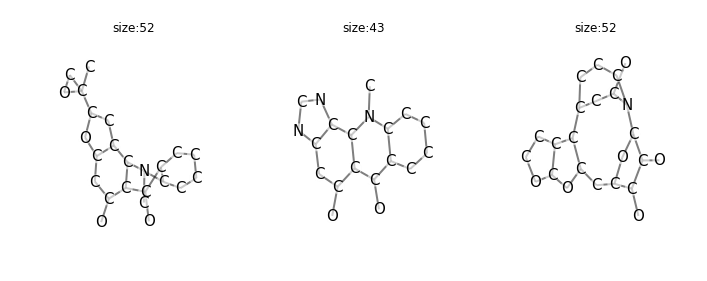

DEBUG:log:select_cip_for_substitution failed because no suiting interface was found, extract failed 20 times 
'NoneType' object has no attribute 'interface_hash'
INFO:log:'NoneType' object has no attribute 'interface_hash'


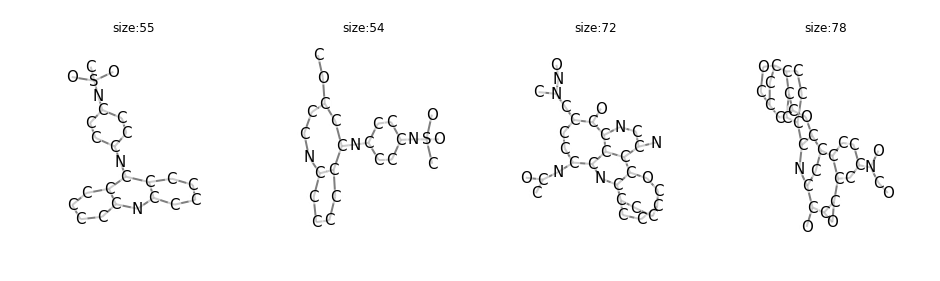

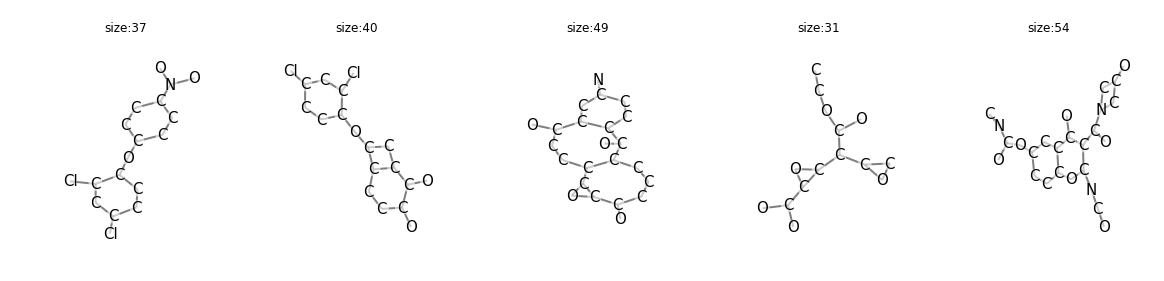

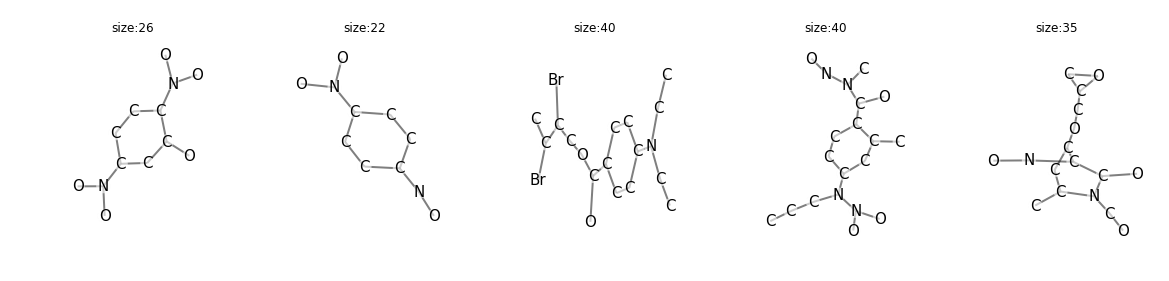

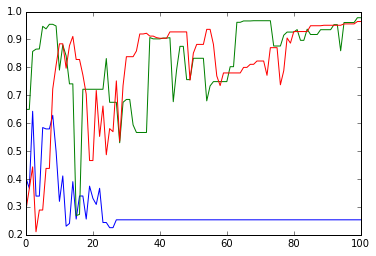

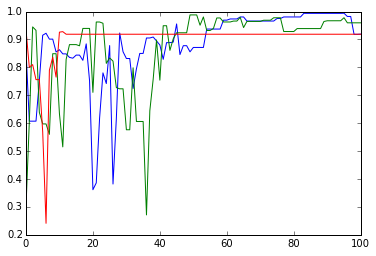

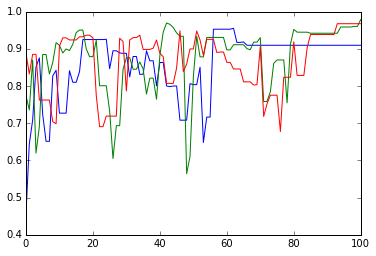

CPU times: user 52.8 s, sys: 1.76 s, total: 54.6 s
Wall time: 1min 8s


In [2]:
%%time
'''
now lets see if we can improve graphs
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt


steps=100

sampler=gl.GraphLearnSampler()
sampler.load('tmp/demo.ge')
print "loading done"
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graphs = itertools.islice(graphs,9)
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=False,
                        sampling_interval=int(steps/3)+1,
                        batch_size=1,
                        n_steps=steps,
                        n_jobs=1,
                        annealing_factor=0.9)

history=[]

for  i, (result,info) in enumerate(graphs):
    history.append(info['score_history'])
    myutils.draw_many_graphs(info['graphs'])
    
    
t = range(steps+1) 
for h in history[:3]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[3:6]:
    plt.plot(t, h)
plt.show()
t = range(steps+1) 
for h in history[6:]:
    plt.plot(t, h)
plt.show()




# HERE BE DRAGONS


In [15]:
'''
inform me when done !
'''
import os
os.system("( speaker-test -t sine -f 2000 )& pid=$! ; sleep 1.0s ; kill -9 $pid")

0

In [ ]:
'''
HERE WE SEE WHY I USE SHUFFLE INSTEAD OF RANDOMCHOICE::: in the select_cips_from_grammar function...
-> pick at random as long as list of used indeces not as long as list?
-> leave it at the shuffeling?
'''
import random
%%time
x= range(1000000,0,-1)
for e in xrange(100):
    i=x.index(random.choice(x)) 
    x.remove(i)


In [ ]:
%%time
x= range(1000000,0,-1)
random.shuffle(x)
for e in xrange(100):
    i=x.pop() 


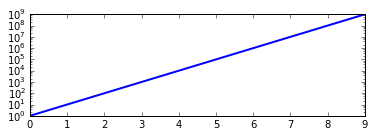

In [3]:
from matplotlib import pyplot

a = [    pow(10,i) for i in range(10)    ]

pyplot.subplot(2,1,1)
pyplot.plot(a, color='blue', lw=2)
pyplot.yscale('log')
pyplot.show()

In [4]:
4 / 5

0

In [3]:
import itertools


def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return itertools.izip_longest(fillvalue=fillvalue, *args)

s="12313141342134234"
[batch for batch in grouper(s,3)]




[('1', '2', '3'),
 ('1', '3', '1'),
 ('4', '1', '3'),
 ('4', '2', '1'),
 ('3', '4', '2'),
 ('3', '4', None)]